In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [9]:
# Step i: Load the Dataset
def load_data(image_dir, img_height=128, img_width=128):
    images, labels = [], []
    class_names = sorted(os.listdir(image_dir))  # Each subdirectory is a class
    print(class_names)
    for label in class_names:
        label_dir = os.path.join(image_dir, label)
        if not os.path.isdir(label_dir):
            continue

        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    image = load_img(image_path, target_size=(img_height, img_width))
                    image = img_to_array(image)
                    images.append(image)
                    labels.append(class_names.index(label))  # 0 for horse, 1 for human
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images, labels, class_names

# Step ii: Split Dataset into Training and Testing Sets
def split_data(images, labels, test_size=0.2):
    return train_test_split(images, labels, test_size=test_size, random_state=42)

# Step iii: Visualize Samples with Labels
def visualize_samples(images, labels, class_names, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

# Step iv: Define Pre-trained Model and Fine-Tune it
def build_pretrained_model(base_model_name, input_shape=(128, 128, 3), learning_rate=0.0001, num_classes=1):
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid model name. Choose from 'ResNet50', 'VGG16', or 'InceptionV3'.")

    # Freeze the base model layers to fine-tune only the added layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='sigmoid')(x)  # For binary classification

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step vii: Fine-tune the Pre-trained Model on the Dataset
def train_model(model, train_images, train_labels, test_images, test_labels, batch_size=32, epochs=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Use data augmentation to help with generalization
    data_augmentation = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    history = model.fit(
        data_augmentation.flow(train_images, train_labels, batch_size=batch_size),
        validation_data=(test_images, test_labels),
        epochs=epochs,
        callbacks=[early_stopping]
    )
    return history

# Step x: Evaluate and Report Results with Confusion Matrix
def evaluate_model(model, test_images, test_labels, class_names):
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the classes for confusion matrix
    predictions = (model.predict(test_images) > 0.5).astype("int32")
    conf_matrix = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return test_loss, test_accuracy



['horses', 'humans']


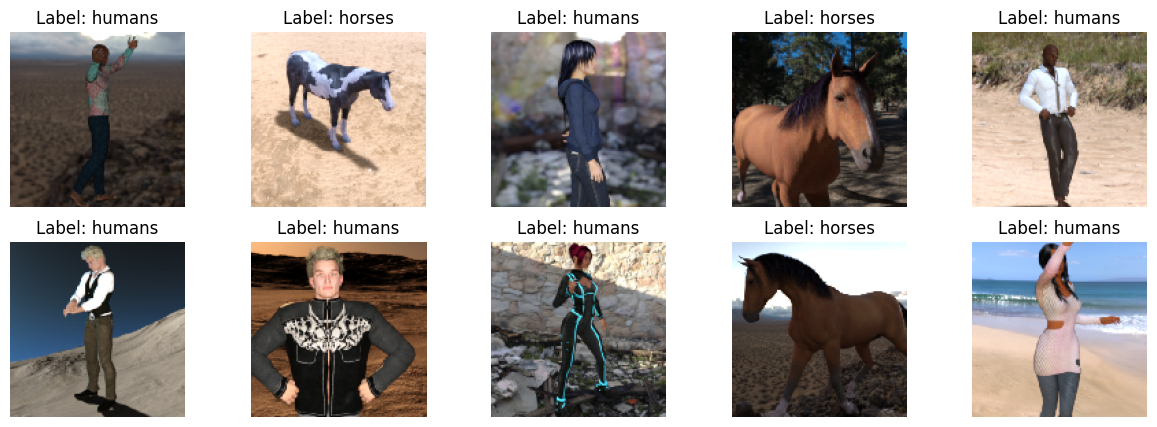

In [12]:
image_dir = './horse-or-human/horse-or-human/horse-or-human'  # Replace with your dataset path
img_height, img_width = 128, 128
batch_size = 32
epochs = 10
learning_rates = [0.0001, 0.0005]  # Experiment with different learning rates
class_names = ['horse', 'human']  # Ensure these are consistent with your labels
    
    # Load and split the dataset
images, labels, class_names = load_data(image_dir, img_height, img_width)
train_images, test_images, train_labels, test_labels = split_data(images, labels, test_size=0.2)
visualize_samples(train_images, train_labels, class_names)
    

In [24]:
    # Define paths and parameters
    
l=['ResNet50', 'VGG16', 'InceptionV3']
lr = 0.0005
model_name = l[2]
# for model_name in l:
print(f"\nTraining with {model_name} and learning rate {lr}")
model = build_pretrained_model(model_name, input_shape=(img_height, img_width, 3), learning_rate=lr)
history = train_model(model, train_images, train_labels, test_images, test_labels, batch_size=batch_size, epochs=epochs)
test_loss, test_accuracy = evaluate_model(model, test_images, test_labels, class_names)
print(f"Results for {model_name} with learning rate {lr}:")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")




Training with InceptionV3 and learning rate 0.0005
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 45s 1us/step


c:\CODE\DL\test\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 532ms/step - accuracy: 0.7264 - loss: 0.7490 - val_accuracy: 0.9854 - val_loss: 0.0467
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.9603 - loss: 0.1220 - val_accuracy: 0.9951 - val_loss: 0.0329
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.9616 - loss: 0.0906 - val_accuracy: 0.9903 - val_loss: 0.0334
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.9759 - loss: 0.0660 - val_accuracy: 0.9951 - val_loss: 0.0172
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.9756 - loss: 0.0799 - val_accuracy: 0.9951 - val_loss: 0.0265
Epoch 6/10
 2/26 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.9766 - loss: 0.1424 

KeyboardInterrupt: 

In [2]:
pip install scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.
